In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import math

from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
matplotlib.rcParams['text.color'] = 'gray'

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

csvs = ['ccj-alpha_1..12.csv',
'rv-counter_1..12.csv',
'ccj-beta-prime_1..12.csv',
'tv-uu_1..12.csv',
'kr-n_1..4.csv',
'pps-arbiter-standard_1..4.csv']

def load_bench(path):
    df = pd.read_csv(path, comment='#')
    df.dropna(axis=1, how='all', inplace=True)
    df.drop('time_unit', axis=1, inplace=True)
    df['deg'] = df['edges'] / df['states']
    return df

def show_bench(bench, ax, nb_bench=4, x='edges', name=None, version='', name_to_label=None):
    nb_aut = len(bench) // nb_bench

    time_unit = 'ns'
    factor = 1
    
    med = bench['real_time'].mean()
    print(med)
    if med > 10**9:
        time_unit = 's'
        factor = 10**-9
    elif med > 10**6:
        time_unit = '\\textmu s'
        factor = 10**-6
    
    for i in range(nb_bench):
        begin = i*nb_aut

        if name != None and name != bench['name'][begin][:-2]:
            continue

        end = (i+1)*nb_aut
        
        label = bench['name'][begin][:-2]
        if not name_to_label is None:
            label = name_to_label[label]
        
        ax.plot(bench[begin:end][x], bench[begin:end]['real_time'] * factor, "-o", label=version + label)
        
    ax.set_xlabel(x)
    ax.set_ylabel('time (' + time_unit + ')')
 
        
def show_speedup(bench, ax,  nb_bench=4, x='edges', version=''):
    nb_aut = len(bench) // nb_bench

    ax.plot(bench[:nb_aut][x], np.ones((nb_aut)))
    ref = bench[:nb_aut].real_time.values
    
    for i in range(1, nb_bench):
        begin = i*nb_aut
        end = (i+1)*nb_aut
                
        ax.plot(bench[begin:end][x], ref / bench[begin:end]['real_time'], "-o", label=version + bench['name'][begin][:-2])
    
    ax.set_xlabel(x)
    ax.set_ylabel('speed up')

    
    
def show_bests(bench, ax, algos=['sim', 'simPar1', 'simPar4', 'simPar8'], nb_bench=4):
    nb_aut = len(bench) // nb_bench

    n_algos = nb_bench
    bests = np.zeros((n_algos, n_algos))

    for i in range(n_algos):
        for j in range(n_algos):
            bench1 = bench[i::nb_bench]
            bench2 = bench[j::nb_bench]

            bests[i,j] = (bench1['real_time'].values > bench2['real_time'].values).sum()

    bests = bests / bests.sum()
    ax.imshow(bests, cmap='gray')
    
    title = 'bests:\n'
    for i in range(len(algos)):
        title += algos[i] + ' -> ' + str(i) + ', '
    ax.title.set_text(title)

def last():
    return sorted(glob.glob('results-*'))[-1]
    
def report(path, type='speed_up', algo1='sim', algo2='simPar8', nb_bench=4, x='edges'):
    bench_csv = glob.glob(path + '/*.{}'.format('csv'))
    
    nb_bench_x = 2
    nb_bench_y = (len(bench_csv) - 1) // nb_bench_x

    (fig, axes) = plt.subplots(nb_bench_x, nb_bench_y, figsize=(30, 15))
    axes = axes.flatten()
    i = 0
    for f in bench_csv:
        if f[-8:] == 'misc.csv' or f[-7:] == 'tmp.csv':
            continue

        bench = load_bench(f)

        if type == 'speed_up':
            show_speedup(bench, axes[i], nb_bench, x)
        else:
            show_bench(bench, axes[i], nb_bench, x)

        axes[i].title.set_text(f)
        i += 1

    plt.legend()

    (fig, axes) = plt.subplots(1, 2, figsize=(10, 5))
    bench = load_bench(path + '/misc.csv')

    show_bests(bench, axes[0])
    plt.title('misc: bests')
    
    show_vs(bench, axes[1], algo2, algo1)
    plt.title('misc: ' + algo1 + ' vs ' + algo2)

    plt.show()

!echo results*

results results-00 results-01


In [2]:
csvs

['ccj-alpha_1..12.csv',
 'rv-counter_1..12.csv',
 'ccj-beta-prime_1..12.csv',
 'tv-uu_1..12.csv',
 'kr-n_1..4.csv',
 'pps-arbiter-standard_1..4.csv']

# Chapter 3 data repartition

In [4]:
#### Generate tab with aut size and origin

all_auts = None
first = True

# Load all genltl and clean them

for csv in csvs:
    if csv == 'misc.csv':
        continue

    tmp = load_bench('results/par4/' + csv)
    tmp = tmp[tmp['name'].str.match('sim//*')]
    tmp['origin'] = csv[:-4]
    tmp['deg'] = np.round(tmp['deg'], 1)
    
    tmp['red_deg'] = tmp['red_edges'] / tmp['red_states']
    tmp['red_deg'] = np.round(tmp['red_deg'], 1)

    tmp['count'] = len(tmp)
    
    tmp.drop('name', inplace=True, axis=1)
    tmp.drop('iterations', inplace=True, axis=1)
    tmp.drop('real_time', inplace=True, axis=1)
    tmp.drop('cpu_time', inplace=True, axis=1)
    
    if first:
        all_auts = tmp
        first = False
    else:
        all_auts = all_auts.append(tmp)
        
# Transform value into range
def srange(col):
    return str(col.min()) + '..' + str(col.max())

all_auts = all_auts.reindex()


for csv in csvs:
    pattern = csv[:-4]
    for col in all_auts.columns:
        if col == 'origin' or col == 'count':
            continue
        r = srange(all_auts[all_auts['origin'] == pattern][col].values)
        all_auts[col][all_auts['origin'] == pattern] = r

        
all_auts.drop_duplicates(inplace=True)

# Add origin
all_auts['type'] = 'genltl | ltl2tgba'
all_auts.set_index(['type', 'origin'], inplace=True)

# Setup the news cols names
all_auts = all_auts.reindex(columns=['states', 'edges', 'deg', 'red_states', 'red_edges', 'red_deg', 'count'])
cols_name = [('reduced', c[4:]) if c[:3] == 'red' else ('orginal', c) for c in all_auts.columns]

# Rename deg in degree
cols_name[2] = (cols_name[2][0], 'degree')
cols_name[5] = (cols_name[5][0], 'degree')

# Reindex the cols (Multindex)
#all_auts.columns = pd.MultiIndex.from_tuples(cols_name)

#all_auts.drop('red_states', inplace=True, axis=1)
#all_auts.drop('red_edges', inplace=True, axis=1)
#all_auts.drop('red_deg', inplace=True, axis=1)

all_auts

#print(all_auts.to_latex())

<ipython-input-4-0c6076d037b2>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_auts[col][all_auts['origin'] == pattern] = r


states      edges         deg  \
type              origin                                                       
genltl | ltl2tgba ccj-alpha_1..12              4..169  10..66417  2.5..393.0   
                  rv-counter_1..12           2..49161   2..49161    1.0..1.0   
                  ccj-beta-prime_1..12         4..169    10..196    1.2..2.5   
                  tv-uu_1..12                  2..377   5..77911  2.5..206.7   
                  kr-n_1..4                   13..134    22..236    1.7..1.8   
                  pps-arbiter-standard_1..4     9..35    19..864   2.1..24.7   

                                            red_states  red_edges     red_deg  \
type              origin                                                        
genltl | ltl2tgba ccj-alpha_1..12               4..169  10..66417  2.5..393.0   
                  rv-counter_1..12            2..49159   2..49159    1.0..1.0   
                  ccj-beta-prime_1..12          4..169    10..196    1.2..2.5   
                  tv-uu_1..12                   2..377   5..77911  2.5..206.7   
                  kr-n_1..4                    10..131    17..231    1.7..1.8   
                  pps-arbiter-standard_1..4      9..35    19..864   2.1..24.7   

                                             count  
type              origin                            
genltl | ltl2tgba ccj-alpha_1..12               12  
                  rv-counter_1..12              12  
                  ccj-beta-prime_1..12          12  
                  tv-uu_1..12                   12  
                  kr-n_1..4                      4  
                  pps-arbiter-standard_1..4      4

# Figure chapter 3 algo improvement 

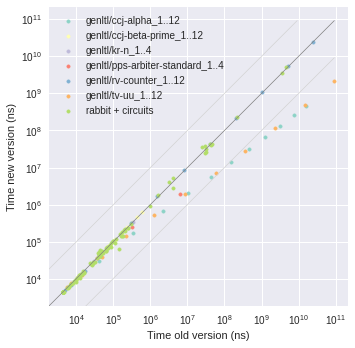

In [7]:
def load_all(path):
    first = True
    all_bench = None

    for csv in csvs:
        tmp = load_bench(path + '/' + csv)
        tmp['source'] = 'genltl/' + csv[:-4]

        if first:
            all_bench = tmp
            first = False
        else:
            all_bench = all_bench.append(tmp)

    tmp = load_bench(path + '/misc.csv')
    tmp['source'] = 'rabbit + circuits'
    all_bench = all_bench.append(tmp)

    return all_bench

def show_vs(bench, ax, algo1, algo2, lim=None, nb_bench=4):
    bench1 = bench[bench['name'].str.match(algo1)]
    bench2 = bench[bench['name'].str.match(algo2)]

    if (len(bench1) == 0):
        raise ValueError('No bench named ' + algo1)
    if (len(bench2) == 0):
        raise ValueError('No bench named ' + algo2)

    lim = max(bench1['real_time'].max(), bench2['real_time'].max())
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xscale('log')
    ax.set_yscale('log')
        
    ax.set_xlabel(algo1)
    ax.set_ylabel(algo2)

    cmap = matplotlib.cm.get_cmap('Set3')    

    i = 0
    for k,d in bench1.groupby('source'):
        b1 = bench1[bench1['source'] == k]
        b2 = bench2[bench2['source'] == k]
        plt.scatter(b1['real_time'], b2['real_time'], marker='.', color=cmap(i), label=k)
        i += 1
    m = bench1['real_time'].max()
    plt.plot([0, m], [0, m], c='gray', linewidth=0.7)
    plt.plot([0, m], [0, m/10], c='lightgray', linewidth=0.7)
    plt.plot([0, m/10], [0, m], c='lightgray', linewidth=0.7)

nb_thread = 'simPar1//*'

path1 = 'results/par4/'
name1 = 'par41'

path2 = 'results/par4_2/'
name2 = 'par42'

big_par4 = load_all(path1)
big_par4 = big_par4[big_par4['name'].str.match(nb_thread)]
big_par4['name'] = name1

big_par4_2 = load_all(path2)
big_par4_2 = big_par4_2[big_par4_2['name'].str.match(nb_thread)]
big_par4_2['name'] = name2

big = big_par4.append(big_par4_2)

with plt.style.context('seaborn'):
    show_vs(big, plt.gca(), name1, name2, nb_bench=1)
    
    plt.xlabel('Time old version (ns)')
    plt.ylabel('Time new version (ns)')

    plt.legend()
#    plt.savefig('algo_improved.pgf')
    plt.show()

# Chapter 3 1er version

In [2]:
b = load_bench('results/par2/ccj-alpha_1..12.csv')

name_to_label = {
    'sim': 'baseline (no parallelism)',
    'simPar1': '1 thread',
    'simPar4': '4 threads',
    'simPar8': '8 threads',
    
}


b['real_time'][12:] = b['real_time'][12:] * 1.02

show_bench(b, plt.gca(), name_to_label=name_to_label)

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**6
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**6

x = b['edges'].max()

l = 'x' + str(round(end_y / start_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y, color="chocolate", ls=':', length_includes_head=True, head_width=1000, head_length=500)
plt.text(x - 5500, start_y + (end_y - start_y) / 2, l)

plt.legend()
#plt.show()
plt.savefig('par2_ccj.pgf')

<ipython-input-2-6daf837200fa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  b['real_time'][12:] = b['real_time'][12:] * 1.02


869450123.328125


1283255113.0695834
12.4678 6.87868 49161


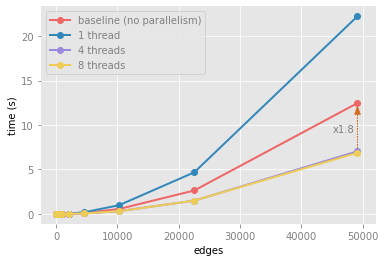

In [14]:
b = load_bench('results/par2/rv-counter_1..12.csv')
show_bench(b, plt.gca(), name_to_label=name_to_label)

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**9
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**9

x = b['edges'].max()
print(end_y, start_y, x)

l = 'x' + str(round(end_y / start_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y - 0.3, color="chocolate", ls=':', length_includes_head=True, head_width=1000, head_length=1)
plt.text(x - 4000, start_y + (end_y - start_y) / 2.4, l)

plt.legend()
plt.show()
#plt.savefig('par2_rv.pgf')

# Chapter 3 2eme version FIXME

1258370118.4014585
13.9814 1.45887 66417


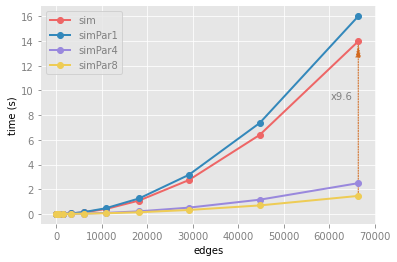

<Figure size 432x288 with 0 Axes>

In [17]:
b = load_bench('results/par4/ccj-alpha_1..12.csv')
show_bench(b, plt.gca())

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**9
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**9

x = b['edges'].max()
print(end_y, start_y, x)

l = 'x' + str(round(end_y / start_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y - 0.3, color="chocolate", ls=':', length_includes_head=True, head_width=1000, head_length=1)
plt.text(x - 6000, start_y + (end_y - start_y) / 1.6, l)

plt.legend()
plt.show()
plt.savefig('par4_ccj.pgf')

5576867525.949375
26.0912 76.4581 49161


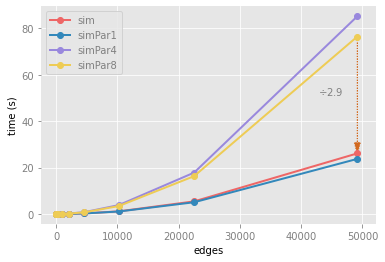

In [22]:
b = load_bench('results/par4/rv-counter_1..12.csv')
show_bench(b, plt.gca())

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**9
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**9

x = b['edges'].max()
print(end_y, start_y, x)

l = '$\div$' + str(round(start_y / end_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y - 0.3, color="chocolate", ls=':', length_includes_head=True, head_width=1000, head_length=5)
plt.text(x - 6500, start_y + (end_y - start_y) / 2, l)

plt.legend()
plt.savefig('par4_rv.pgf')

1263268.826875
7.17949 1.96607 864


/home/jerome/.local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jerome/.local/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


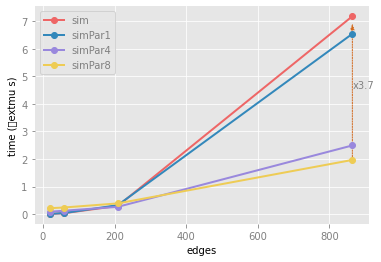

<Figure size 432x288 with 0 Axes>

In [20]:
b = load_bench('results/par4/pps-arbiter-standard_1..4.csv')
show_bench(b, plt.gca())

start_y = b[b['name'].str.match('simPar8//*')]['real_time'].max() / 10**6
end_y = b[b['name'].str.match('sim//*')]['real_time'].max() / 10**6

x = b['edges'].max()
print(end_y, start_y, x)

l = 'x' + str(round(end_y / start_y, 1))

plt.arrow(x, start_y, 0, end_y - start_y - 0.3, color="chocolate", ls=':', length_includes_head=True, head_width=10, head_length=0.2)
plt.text(x, start_y + (end_y - start_y) / 2, l)

plt.legend()
plt.show()
plt.savefig('par4_pps.pgf')